In [7]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn import preprocessing
import warnings
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import math
import numpy
import random
import scipy.special as special
import tqdm
import gc
import pickle
import xgboost as xgb

In [8]:
def feat_select(train, test):
  
    features = train.drop(['is_trade', 'time', 'context_timestamp','user_id','context_id','instance_id','item_id','shop_id','item_brand_id'], axis=1).columns.tolist() #,'item_property_list','predict_category_property'

    target = ['is_trade']

    return features, target

In [9]:
path = '/Users/apple/Desktop/data/basicclick_data/'
data = pd.read_csv(path+"rate_final_data_12-01-10-41.csv")
train = pd.read_csv(path+"train_day7.csv")
train = train[['instance_id']]
train =pd.merge(train, data, how='left', on='instance_id')
train

,instance_id,item_id,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,user_id,user_gender_id,...,i_day_diffTime_first,i_day_diffTime_last,b_day_diffTime_first,b_day_diffTime_last,s_day_diffTime_first,s_day_diffTime_last,user_id_lasttime_diff,item_id_lasttime_diff,user_id_nexttime_diff,item_id_nexttime_diff
0,7.608450e+18,8073,2885,110,8,10,10,16,65580,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,4.572110e+18,9056,3781,67,5,13,15,15,45054,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,8.091750e+18,20494,831,2,7,10,11,17,19162,0,...,-30405,30792,-1,-1,-1,-1,-1,-30405,-1,30405
3,7.251110e+18,8064,286,34,6,14,13,17,61692,0,...,4562,-7283,-1,-1,-1,-1,-1,10461,-1,-10461
4,5.545850e+18,37,4316,80,8,13,13,18,53854,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8142,5.568580e+18,4716,736,157,9,6,12,17,56362,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
8143,2.780010e+18,9544,2107,80,7,11,10,15,11383,1,...,0,-4121,-1,-1,-1,-1,-1,-1,-1,-1
8144,2.230740e+18,2659,730,74,6,12,11,16,27350,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
8145,2.144820e+18,6388,5385,110,7,15,16,18,61852,0,...,27437,-668,-1,-1,-1,-1,-1,27437,-1,-27437


In [10]:
test = pd.read_csv(path+"test_day7.csv")
test = test[['instance_id']]
test = pd.merge(test, data, how='left', on='instance_id')
test

,instance_id,item_id,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,user_id,user_gender_id,...,i_day_diffTime_first,i_day_diffTime_last,b_day_diffTime_first,b_day_diffTime_last,s_day_diffTime_first,s_day_diffTime_last,user_id_lasttime_diff,item_id_lasttime_diff,user_id_nexttime_diff,item_id_nexttime_diff
0,1.045000e+18,14038,4797,2,7,14,15,21,16213,0,...,0,36378,-1,-1,-1,-1,-1,-1,-1,-1
1,3.427500e+17,2405,5894,147,7,12,15,20,62843,1,...,0,-25474,-1,-1,-1,-1,-1,-1,-1,-1
2,4.802540e+18,6956,5385,84,7,11,11,17,86913,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,1.290980e+18,4677,4797,2,8,11,13,20,54861,0,...,12351,-19224,-1,-1,-1,-1,-1,12351,-1,-12351
4,1.790920e+18,14874,1581,2,7,12,14,18,91399,0,...,-12766,0,-1,-1,-1,-1,-1,-7525,-1,7525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,6.748800e+18,11250,5992,21,6,12,12,17,80631,2,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2033,1.967530e+18,11025,5385,21,7,8,8,14,29871,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2034,4.601280e+18,16654,1253,70,9,9,13,16,29961,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2035,4.671890e+18,5666,2615,128,8,10,10,17,11014,-1,...,0,6318,-1,-1,-1,-1,-1,-1,-1,-1


In [11]:
train = train.drop('day_y', axis=1)
train = train.drop('is_trade_y', axis=1)
train = train.rename(columns={'day_x': 'day'})
train = train.rename(columns={'is_trade_x': 'is_trade'})

In [12]:
test = test.drop('day_y', axis=1)
test = test.drop('is_trade_y', axis=1)
test = test.rename(columns={'day_x': 'day'})
test = test.rename(columns={'is_trade_x': 'is_trade'})

In [13]:
from xgboost import plot_importance

def xgbCV(train, test):
    
    features, target = feat_select(train, test)
    
    X = train[features]
    y = train[target]
    X_tes = test[features]
    y_tes = test[target]

    print('Training XGB model...')
    X_train_set = xgb.DMatrix(X, label=y, missing=np.nan)
    X_validate_set = xgb.DMatrix(X_tes, label=y_tes, missing=np.nan)
    watchlist = [(X_train_set, 'train'), (X_validate_set, 'eval')]
    params = {'max_depth':7,
              'nthread': 25,
              'eta': 0.01,
            #   'eval_metric': 'logloss',
              'objective': 'binary:logistic',
              'subsample': 0.85,
              'colsample_bytree': 0.85,
              'silent': 1,
              'seed': 0,
              'min_child_weight': 6
              #'scale_pos_weight':0.5
              }
    gbm = xgb.train(params, X_train_set, evals=watchlist, early_stopping_rounds=50) #, num_boost_round=3000
    plot_importance(gbm)

    best_iter_num = gbm.best_iteration
    return best_iter_num,gbm


Training XGB model...
[10:57:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-logloss:0.68491	eval-logloss:0.68486
[1]	train-logloss:0.67679	eval-logloss:0.67669
[2]	train-logloss:0.66883	eval-logloss:0.66874
[3]	train-logloss:0.66105	eval-logloss:0.66089
[4]	train-logloss:0.65338	eval-logloss:0.65317
[5]	train-logloss:0.64589	eval-logloss:0.64565
[6]	train-logloss:0.63855	eval-logloss:0.63830
[7]	train-logloss:0.63136	eval-logloss:0.63107
[8]	train-logloss:0.62430	eval-logloss:0.62398
[9]	train-logloss:0.61735	eval-logloss:0.61697


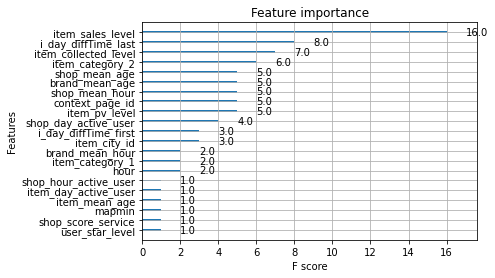

In [14]:
best_iter,gbm = xgbCV(train, test)

In [15]:
best_iter

9

In [16]:
type(gbm)

xgboost.core.Booster

In [17]:
import operator
importance = gbm.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1),reverse=True)
pd.DataFrame(importance).to_csv('xgb_feat_imp_day7.csv',index=False)